In [1]:
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from PIL import Image
import tensorflow as tf

In [2]:
BATCH = 26
IMG_WIDTH = 96
IMG_HEIGHT = 96

In [3]:
train_loader = tf.keras.preprocessing.image_dataset_from_directory('D:/Other Projects/Crack detection/dataAug/heatMaps/train', seed=123, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH)
test_loader = tf.keras.preprocessing.image_dataset_from_directory('D:/Other Projects/Crack detection/dataAug/heatMaps/test', seed=123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH)
validation_loader = tf.keras.preprocessing.image_dataset_from_directory('D:/Other Projects/Crack detection/dataAug/heatMaps/val', seed=123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH)

Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


In [4]:
class_names = train_loader.class_names
print(class_names)

['Negative', 'Positive']


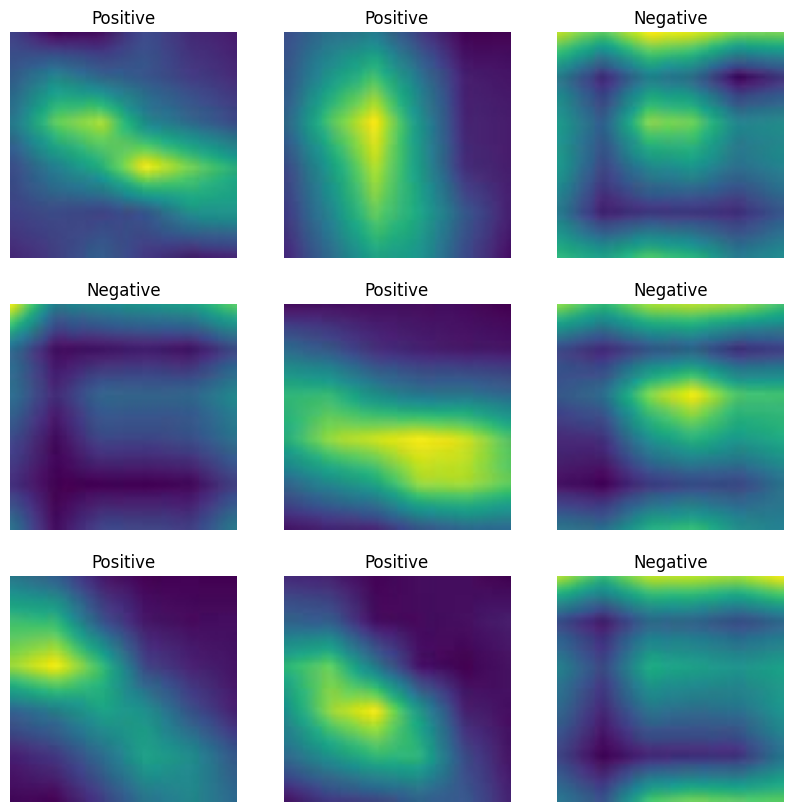

In [5]:
plt.figure(figsize = (10, 10))
for images, labels in train_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_loader.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_loader.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = validation_loader.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
  
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                  

In [9]:
epochs = 50
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/50
16/16 [==============================] - 8s 233ms/step - loss: 0.5030 - accuracy: 0.7600 - val_loss: 0.2927 - val_accuracy: 0.8975
Epoch 2/50
16/16 [==============================] - 2s 149ms/step - loss: 0.2462 - accuracy: 0.9175 - val_loss: 0.1156 - val_accuracy: 0.9575
Epoch 3/50
16/16 [==============================] - 2s 147ms/step - loss: 0.1078 - accuracy: 0.9625 - val_loss: 0.0397 - val_accuracy: 0.9875
Epoch 4/50
16/16 [==============================] - 2s 139ms/step - loss: 0.0453 - accuracy: 0.9825 - val_loss: 0.0932 - val_accuracy: 0.9750
Epoch 5/50
16/16 [==============================] - 2s 153ms/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 0.0520 - val_accuracy: 0.9875
Epoch 6/50
16/16 [==============================] - 2s 155ms/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 0.0562 - val_accuracy: 0.9950
Epoch 7/50
16/16 [==============================] - 2s 152ms/step - loss: 0.0231 - accuracy: 0.9900 - val_loss: 0.0767 - val_accuracy: 0.9900
Epoch 

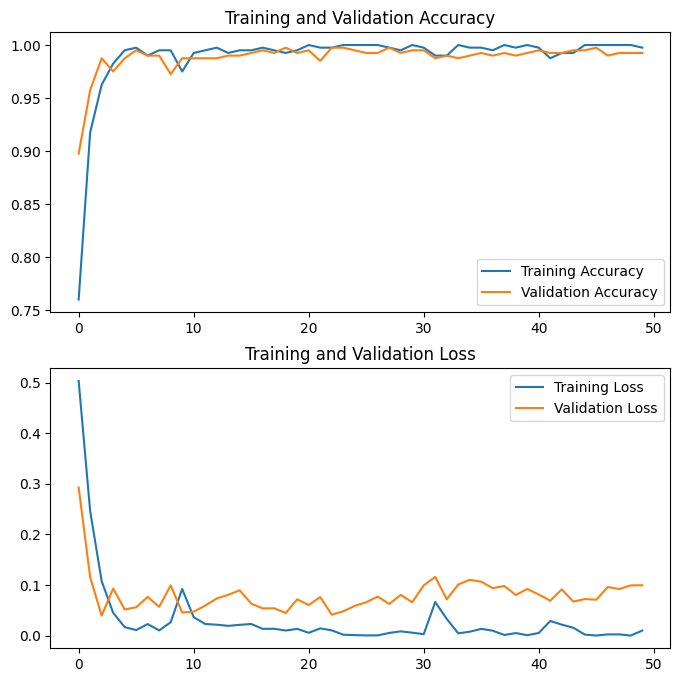

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
loss, accuracy = model.evaluate(test_dataset)

16/16 [==============================] - 1s 41ms/step - loss: 3.3895e-05 - accuracy: 1.0000


1/1 [==============================] - 0s 64ms/step


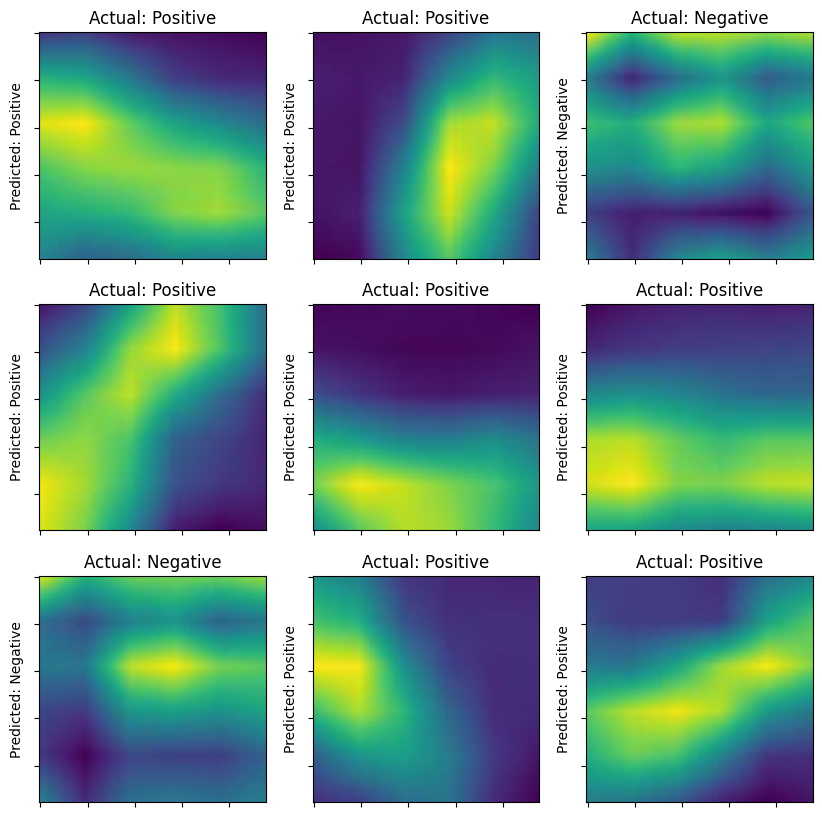

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in test_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        plt.ylabel("Predicted: "+class_names[np.argmax(score)])
        plt.title("Actual: "+class_names[labels[i]])
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])